In [1]:
%matplotlib inline
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
import copy
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


In [3]:
# del cnn
torch.cuda.empty_cache()
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [4]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    
    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [5]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [6]:
STYLE_LAYERS_TRANSLATION = {'conv_1': 'conv1_1',
                            'conv_2': 'conv1_2',

                            'conv_3': 'conv2_1',
                            'conv_4': 'conv2_2',

                            'conv_5': 'conv3_1',
                            'conv_6': 'conv3_2',
                            'conv_7': 'conv3_3',
                            'conv_8': 'conv3_4',

                            'conv_9': 'conv4_1',
                            'conv_10': 'conv4_2',
                            'conv_11': 'conv4_3',
                            'conv_12': 'conv4_4',

                            'conv_13': 'conv5_1',
                            'conv_14': 'conv5_2',
                            'conv_15': 'conv5_3',
                            'conv_16': 'conv5_4'}

# ====================



In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [8]:
class ContextualLoss(nn.Module):    
    def __init__(self, target_features, epsilon=1e-5, h=0.2):
        super(ContextualLoss, self).__init__()
        target = ContextualLoss._vectorize_features(target_features).detach()
        self.mu = torch.mean(target, 0)  # We assume feaure_vecotr = column
                                         # dim=1 for feature_vector=row
        self.target = target - self.mu  # centeralized features
        self.epsilon = epsilon
        self.h = h
        
    def forward(self, input):
        # {Y} = target features = style
        # {X} = source features = noise
        # y_j = one feature of the style image
        # x_i = one feature of the noise image
        
        features = ContextualLoss._vectorize_features(input)
        
        # if |X|!=|Y| sample N from the bigger set
        X_features = features - self.mu  # cenetralize the features
        N = self.target.shape[1]
        
#         CXs = torch.zeros(N, N)  # matrix containing in each row the CXij for that 
#                                  # feature i from the source image (compared to j 
#                                  # feature from target, which is in the column)
        CXs_max = torch.zeros(N)
        print(len(X_features.T))
        for idx, xi in enumerate(X_features.T):  # iterate over columns
            xi = xi.view(-1,1)
            
            di = xi.repeat(1, N).to(device='cpu')
            di = nn.functional.cosine_similarity(di, self.target.to(device='cpu'), dim=0)
#             di = nn.functional.cosine_similarity(di, self.target, dim=0)
            # SMALL d_ik = similar
            
            di_tilde = di / (di.min() + self.epsilon)
            del di
            # dij compared to the minimum d from THIS xi to ALL Y
            
            wi = torch.exp((1-di_tilde) / self.h)
            del di_tilde
            # d~_ij=1 -> w_ij=1 ; 
            # d~_ij > 1 -> 0< W_ij smaller < 1
            # d~_ij < 1 -> W_ij bigger > 1 <<<<<<<<<<<< want!
        
            Zi = wi.sum()
            CXi = wi / Zi
            del Zi
            del wi
#             CXs[idx,:] = CXi  
            CXs_max = torch.max(CXs_max, CXi.to(device='cpu'))
            del CXi
        
        print('h')
        most_similar_xs, _ = CXs_max.max(dim=0)
        CX = most_similar_xs.mean()  # most_similar_xs.sum() / len(most_similar_xs)
        
        self.loss = -torch.log(CX)      
        return input
    
    @staticmethod
    def _vectorize_features(features):
        batch_size, depth, c, d = features.size() 
        # batch size(=1)
        # depth = number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)
        
        # resise F_XL into \hat F_XL
        return features.view(batch_size * depth, c * d)[10:50] 

# ====================

In [9]:
# desired size of the output image
#imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
imsize=64

#GAUSSIAN_BLUR = 8

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name) #.convert('RGB')
    #image = image.filter(ImageFilter.GaussianBlur(GAUSSIAN_BLUR))
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/starry_night_full.jpg")
#content_img = image_loader("./images/.jpg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

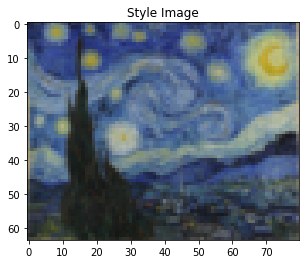

In [10]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, title):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(title)

plt.figure()
imshow(style_img, title='Style Image')

# plt.figure()
# imshow(content_img, title='Content Image')

In [11]:
# class ContentLoss(nn.Module):

#     def __init__(self, target,):
#         super(ContentLoss, self).__init__()
#         # we 'detach' the target content from the tree used
#         # to dynamically compute the gradient: this is a stated value,
#         # not a variable. Otherwise the forward method of the criterion
#         # will throw an error.
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input

In [12]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, #content_img,
                               #content_layers,
                               style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
#     content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
      

        model.add_module(name, layer)

#         if name in content_layers:
#             # add content loss:
#             target = model(content_img).detach()
#             content_loss = ContentLoss(target)
#             model.add_module("content_loss_{}".format(i), content_loss)
#             content_losses.append(content_loss)

        if name.startswith('conv') and STYLE_LAYERS_TRANSLATION[name] in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
#            style_loss = StyleLoss(target_feature)
#             model.add_module("style_loss_{}".format(i), style_loss)
            contx_loss = ContextualLoss(target_feature)
            model.add_module("contx_loss_{}".format(i), contx_loss)

#             style_losses.append(style_loss)
            style_losses.append(contx_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
#         if isinstance(model[i], StyleLoss): #or isinstance(model[i], ContentLoss):
        if isinstance(model[i], contx_loss): #or isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses#, content_losses
#     return model, style_losses#, content_losses

In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    # optimizer = optim.Adam([target], lr=0.003)
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       #content_img, 
                       style_img, input_img,
                       style_layers, style_weights,
                       num_steps=300, style_weight=1000000):#, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
#     model, style_losses, content_losses = get_style_model_and_losses(cnn,
    model, style_losses = get_style_model_and_losses(cnn, 
        normalization_mean, normalization_std, style_img, style_layers)#, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing..')
    run = [0]
    losses = []
    start_time = [time.time()]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
#             content_score = 0

            for i, sl in enumerate(style_losses):
                style_score += style_weights[i] * sl.loss
#             for cl in content_losses:
#                 content_score += cl.loss

            style_score *= style_weight
#             content_score *= content_weight

            loss = style_score # + content_score
            losses.append(float(loss))
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:\t\tStyle loss: {:4f}".format(run, style_score.item()),end="\t\t")
                print(f"Time: {time.time()-start_time[0]}")
                start_time[0] = time.time()
#                 print('Style Loss : {:4f} Content Loss: {:4f}'.format(
#                     style_score.item(), content_score.item()))
                #print('Style Loss : {:4f} '.format(style_score.item()))
                #print()
            if run[0] % 500 == 0:
                vis_img = copy.deepcopy(input_img)
                plt.figure()
                imshow(vis_img, title=f'On run {run[0]}')
        
            return style_score #+ content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img, losses

torch.Size([1, 3, 64, 80])


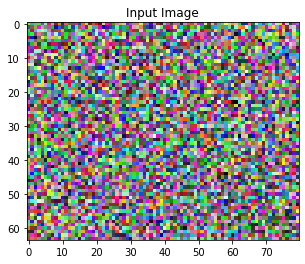

In [15]:
# input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
base_img = torch.randn(style_img.data.size(), device=device)
#base_img = torch.poisson(base_img) #torch.zeros_like(style_img, device=device) #
print(style_img.shape)
#base_img[0,:,0:250,:] = 1
# add the original input image to the figure:
plt.figure()
imshow(base_img, title='Input Image')

In [16]:

input_img = copy.deepcopy(base_img)

STYLE_LAYERS = ['conv1_1', 'conv2_1']#, 'conv3_1', 'conv4_1', 'conv5_1']#, 'conv_3', 'conv_4', 'conv_5']
# STYLE_LAYERS = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8']
#STYLE_WEIGHTS = np.array([1,0.75,0.2,0.2,0.2])
STYLE_WEIGHTS = np.array([1,1,1,1,1])
# STYLE_WEIGHTS = np.ones(len(STYLE_LAYERS))
EPOCHS = 1000
start_time = time.time()
output, losses = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, 
                            style_img, input_img,  
                            STYLE_LAYERS, STYLE_WEIGHTS,
                            num_steps=EPOCHS)
end_time = time.time()
print(f"The training process took {end_time-start_time}")

plt.figure()
imshow(output, title='Output Image')

fig = plt.figure(figsize=(16,10))
fig.add_subplot(2,2,1)
plt.plot(losses) 
plt.title('Losses vs Iter')
fig.add_subplot(2,2,2)
plt.plot(np.log10(losses)) 
plt.title('log10(Losses) vs Iter')
fig.add_subplot(2,2,3)
plt.plot(np.arange(len(losses))[-50:], losses[-50:]) 
plt.title('Zoomed Losses vs Iter')
fig.add_subplot(2,2,4)
plt.plot(np.arange(len(losses))[-50:], np.log10(losses[-50:])) 
plt.title('Zoomed log10(Losses) vs Iter')

imsave(output, f'outputs/sn_contxLossv1_{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
fig.savefig(f'outputs/sn_contxLossv1_{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..


F:\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
F:\anaconda3\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


5120
h


TypeError: isinstance() arg 2 must be a type or tuple of types

In [ ]:
print(f'Used GPUmem in GB: {torch.cuda.memory_allocated() /1024 /1024/1024}')
torch.cuda.synchronize()
print(f'Used GPUmem in GB: {torch.cuda.memory_allocated() /1024 /1024/1024}')
torch.cuda.empty_cache()
print(f'Used GPUmem in GB: {torch.cuda.memory_allocated() /1024 /1024/1024}')
#del cnn
torch.cuda.synchronize()
print(f'Used GPUmem in GB: {torch.cuda.memory_allocated() /1024 /1024/1024}')
torch.cuda.empty_cache()
print(f'Used GPUmem in GB: {torch.cuda.memory_allocated() /1024 /1024/1024}')
import gc
print(f'Cached Memoy: {torch.cuda.memory_cached()/1024/1024/1024}')
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size())
#     except:
#         pass

In [ ]:
# a = copy.deepcopy(output)
# imshow(output-a, title='Sub Img')
#imsave(output, f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
# fig = plt.figure(figsize=(18,10))
# fig.add_subplot(2,2,1)
# plt.plot(losses) 
# plt.title('Losses vs Iter')
# fig.add_subplot(2,2,2)
# plt.plot(np.log10(losses)) 
# plt.title('log10(Losses) vs Iter')
# fig.add_subplot(2,2,3)
# plt.plot(np.arange(len(losses))[-50:], losses[-50:]) 
# plt.title('Zoomed Losses vs Iter')
# fig.add_subplot(2,2,4)
# plt.plot(np.arange(len(losses))[-50:], np.log10(losses[-50:])) 
# plt.title('Zoomed log10(Losses) vs Iter')
# fig.savefig(f'outputs/fixed_sn_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')
# plt.figure()
# imshow(output, title='Output Image')

# fig = plt.figure(figsize=(16,10))
# fig.add_subplot(2,2,1)
# plt.plot(losses) 
# plt.title('Losses vs Iter')
# fig.add_subplot(2,2,2)
# plt.plot(np.log10(losses)) 
# plt.title('log10(Losses) vs Iter')
# fig.add_subplot(2,2,3)
# plt.plot(np.arange(len(losses))[-500:], losses[-500:]) 
# plt.title('Zoomed Losses vs Iter')
# fig.add_subplot(2,2,4)
# plt.plot(np.arange(len(losses))[-500:], np.log10(losses[-500:])) 
# plt.title('Zoomed log10(Losses) vs Iter')

# #imsave(output, f'outputs/black_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}.png')
# #fig.savefig(f'outputs/black_up2{STYLE_LAYERS[-1]}_e{EPOCHS}_w{STYLE_WEIGHTS}_fig.png')

# # sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.show()

In [ ]:
%qtconsole